# 1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow opencv-python matplotlib

In [ ]:
!pip list

In [990]:
import tensorflow as tf
import os

In [991]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [992]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [993]:
import cv2
import imghdr

In [994]:
data_dir = 'data' 

In [995]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [996]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [997]:
import numpy as np
from matplotlib import pyplot as plt

In [998]:
data = tf.keras.utils.image_dataset_from_directory('data')
#data = tf.keras.utils.image_dataset_from_directory('data', image_size=(150,150))

Found 240 files belonging to 10 classes.


In [999]:
data_iterator = data.as_numpy_iterator()

In [1000]:
batch = data_iterator.next()

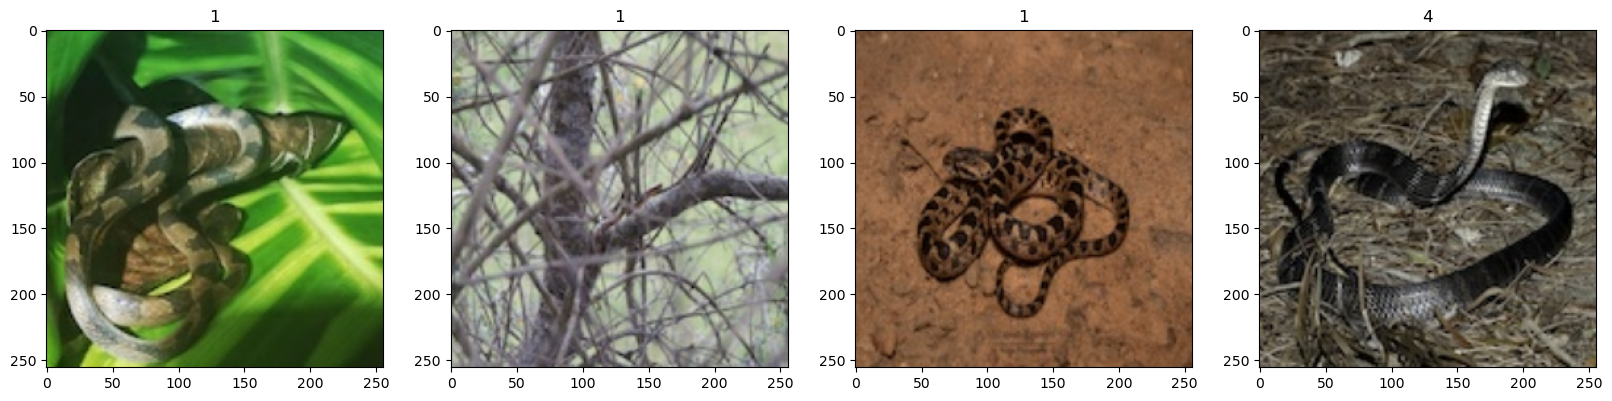

In [1001]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [1002]:
data = data.map(lambda x,y: (x/255, y))
#data = data.map(lambda x,y: (x, y))

In [ ]:
data.as_numpy_iterator().next()

# 5. Split Data

In [1018]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [1019]:
print(len(data))
print(train_size)
print(val_size)
print(test_size)

8
5
2
1


In [1020]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [1021]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [1022]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout



In [1023]:
model = Sequential()

In [1024]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
#model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(150,150,3)))

model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

In [1025]:
#model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [1026]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_87 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_79 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_88 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_80 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_89 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_81 (MaxPooli  (None, 30, 30, 16)      

# 7. Train

In [1027]:
logdir='logs'

In [1028]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [1029]:
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15
5/5 [==============================] - 1s 265ms/step - loss: 2.5049 - accuracy: 0.1063 - val_loss: 2.2852 - val_accuracy: 0.1562
Epoch 2/15
5/5 [==============================] - 1s 244ms/step - loss: 2.2659 - accuracy: 0.1937 - val_loss: 2.2846 - val_accuracy: 0.0781
Epoch 3/15
5/5 [==============================] - 1s 238ms/step - loss: 2.2403 - accuracy: 0.2000 - val_loss: 2.1919 - val_accuracy: 0.2812
Epoch 4/15
5/5 [==============================] - 1s 234ms/step - loss: 2.1127 - accuracy: 0.2625 - val_loss: 1.9063 - val_accuracy: 0.3438
Epoch 5/15
5/5 [==============================] - 1s 234ms/step - loss: 1.9263 - accuracy: 0.3562 - val_loss: 1.7345 - val_accuracy: 0.5156
Epoch 6/15
5/5 [==============================] - 1s 240ms/step - loss: 1.6536 - accuracy: 0.5188 - val_loss: 1.7065 - val_accuracy: 0.4688
Epoch 7/15
5/5 [==============================] - 1s 242ms/step - loss: 1.6862 - accuracy: 0.4250 - val_loss: 1.2832 - val_accuracy: 0.5156
Epoch 8/15
5/5 [====

# 8. Plot Performance

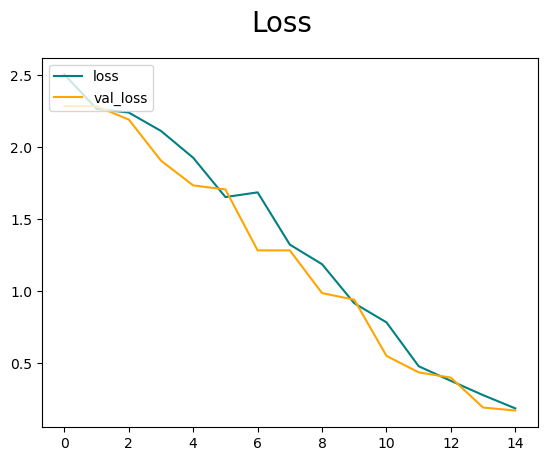

In [1030]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

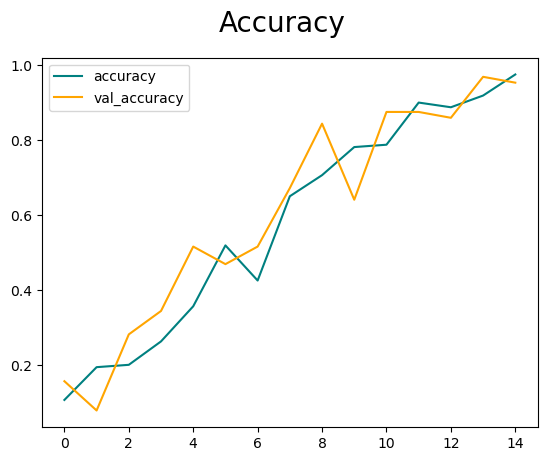

In [1031]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 8.5 Confusion Matrix

In [1032]:
from sklearn.metrics import confusion_matrix

In [1033]:
#print(len(train))
#print(len(train))
for batch in train.as_numpy_iterator(): 
    X, y = batch
    #print(len(X))
    #print(y)
    yhat = np.argmax(model.predict(X), axis=1)
    cm = confusion_matrix(y, yhat)
    #print(y)
    #print(yhat)
    print(cm)

1/1 [==============================] - 0s 90ms/step
[[3 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 7]]
1/1 [==============================] - 0s 63ms/step
[[2 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 6 0 0 0]
 [0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 2]]
1/1 [==============================] - 0s 63ms/step
[[8 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 1 0 2 0 0 0 0]
 [0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 1]]
1/1 [==============================] - 0s 71ms/step
[[3 0 0 0 0 0 0 0 0 0]
 [0 4 1 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 1 2 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 6 0 0 0 0]
 [

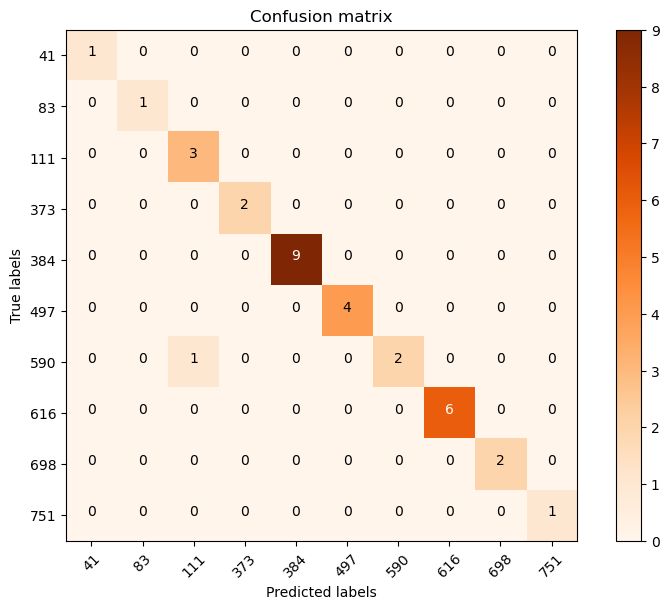

In [1034]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    """
    arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """
     
    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()
    
    
    
# a tuple for all the class names
target_names = ('41', '83', '111', '373', '384', 
                 '497', '590', '616', '698', '751')
plot_confusion_matrix(cm, target_names)

# 9. Evaluate

In [1035]:
from tensorflow.keras.metrics import Precision, Recall, sparse_categorical_accuracy

In [1036]:
pre = Precision()
re = Recall()
#acc = BinaryAccuracy()

In [1037]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = np.argmax(model.predict(X), axis=1)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    #acc.update_state(y, yhat)

1/1 [==============================] - 0s 64ms/step


In [1038]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
acc = sparse_categorical_accuracy(y, yhat)


1/1 [==============================] - 0s 40ms/step


In [1039]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{np.mean(acc)}, F1 Score:{2/(1/pre.result().numpy()+(1/re.result().numpy()))}')

Precision:1.0, Recall:1.0, Accuracy:0.9375, F1 Score:1.0


# 10. Test

In [67]:
import cv2

In [ ]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [41]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
yhat

In [ ]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

# 11. Save the Model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('models','imageclassifier.h5'))

In [46]:
new_model = load_model('imageclassifier.h5')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))